## initial model

Initial model development.

In [1]:
import torchvision

_PascalVOCSegmentationDataset = torchvision.datasets.VOCSegmentation(
    '/mnt/pascal_voc_segmentation/', year='2012', image_set='train', download=True,
    transform=None, target_transform=None, transforms=None
)

Using downloaded and verified file: /mnt/pascal_voc_segmentation/VOCtrainval_11-May-2012.tar


In [2]:
from torch.utils.data import Dataset
import numpy as np
import PIL

class PascalVOCSegmentationDataset(Dataset):
    def __init__(self, raw):
        super().__init__()
        self._dataset = raw
        self.resize_img = torchvision.transforms.Resize((256, 256), interpolation=PIL.Image.BILINEAR)
        self.resize_segmap = torchvision.transforms.Resize((256, 256), interpolation=PIL.Image.NEAREST)
    
    def __len__(self):
        return len(self._dataset)
    
    def __getitem__(self, idx):
        img, segmap = self._dataset[idx]
        img, segmap = self.resize_img(img), self.resize_segmap(segmap)
        img, segmap = np.array(img), np.array(segmap)
        img, segmap = (img / 255).astype('float32'), segmap.astype('int32')
        img = np.transpose(img, (-1, 0, 1))

        # because the dataset has edges labeled as 255, but pytorch wants contiguous values, so we
        # relabel
        segmap[segmap == 255] = 21
        
        return img, segmap

dataset = PascalVOCSegmentationDataset(_PascalVOCSegmentationDataset)

In [3]:
ex_img, ex_segmap = dataset[0]
print(ex_img.shape)
print(ex_segmap.shape)

(3, 256, 256)
(256, 256)


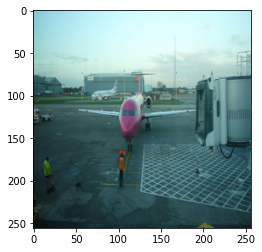

In [5]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(ex_img, (1, -1, 0)))

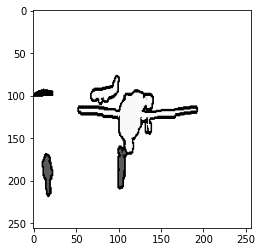

In [6]:
plt.imshow(ex_segmap, cmap='Greys')

In [7]:
from torch.utils.data import DataLoader

# batch_size=1 just for testing purposes!
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

In [8]:
ex_img_batch, ex_segmap_batch = next(iter(dataloader))

In [9]:
ex_img_batch.shape

torch.Size([8, 3, 256, 256])

In [10]:
ex_segmap_batch.shape

torch.Size([8, 256, 256])

In [11]:
ex_img_batch.dtype

torch.float32

In [12]:
np.unique(ex_segmap_batch)

array([ 0,  1,  3,  4,  5,  9, 12, 15, 20, 21], dtype=int32)

In [13]:
(ex_segmap_batch == 255).sum()

tensor(0)

In [14]:
DeepLabV3 = torchvision.models.segmentation.deeplabv3_resnet101(
    pretrained=False, progress=True, num_classes=22, aux_loss=None
)

In [15]:
model = DeepLabV3
model.cuda()
pass

In [16]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'/spell/tensorboards/model_1')

In [17]:
import torch.nn as nn
from torch.optim import Adam

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [21]:
import torch 

def train(NUM_EPOCHS):
    for epoch in range(1, NUM_EPOCHS + 1):
        losses = []

        for i, (batch, segmap) in enumerate(dataloader):
            optimizer.zero_grad()

            batch = batch.cuda()
            segmap = segmap.cuda()

            output = model(batch)['out']
            # import pdb; pdb.set_trace()
            loss = criterion(output, segmap.type(torch.int64))
            loss.backward()
            optimizer.step()

            curr_loss = loss.item()
            if i % 10 == 0:
                print(
                    f'Finished epoch {epoch}, batch {i}. Loss: {curr_loss:.3f}.'
                )

            writer.add_scalar(
                'training loss', curr_loss, epoch * len(dataloader) + i
            )
            losses.append(curr_loss)

        print(
            f'Finished epoch {epoch}. '
            f'avg loss: {np.mean(losses)}; median loss: {np.min(losses)}'
        )
        if not os.path.exists('/spell/checkpoints/'):
            os.mkdir('/spell/checkpoints/')
        torch.save(model.state_dict(), f'/spell/checkpoints/model_{epoch}.pth')

In [22]:
train(5)

Finished epoch 1, batch 0. Loss: 2.990.
Finished epoch 1, batch 10. Loss: 1.913.


KeyboardInterrupt: 

In [1]:
!mkdir ../models/

In [4]:
%%writefile ../models/1_initial_model.py
import torch
import torchvision
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import PIL
import torch.nn as nn
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

_PascalVOCSegmentationDataset = torchvision.datasets.VOCSegmentation(
    '/mnt/pascal_voc_segmentation/', year='2012', image_set='train', download=True,
    transform=None, target_transform=None, transforms=None
)

# VOCSegmentation returns a raw dataset: images are non-resized and in the PIL format. To transform them
# something suitable for input to PyTorch, we need to wrap the output in our own dataset class.
class PascalVOCSegmentationDataset(Dataset):
    def __init__(self, raw):
        super().__init__()
        self._dataset = raw
        self.resize_img = torchvision.transforms.Resize((256, 256), interpolation=PIL.Image.BILINEAR)
        self.resize_segmap = torchvision.transforms.Resize((256, 256), interpolation=PIL.Image.NEAREST)
    
    def __len__(self):
        return len(self._dataset)
    
    def __getitem__(self, idx):
        img, segmap = self._dataset[idx]
        img, segmap = self.resize_img(img), self.resize_segmap(segmap)
        img, segmap = np.array(img), np.array(segmap)
        img, segmap = (img / 255).astype('float32'), segmap.astype('int32')
        img = np.transpose(img, (-1, 0, 1))

        # The PASCAL VOC dataset PyTorch provides labels the edges surrounding classes in 255-valued
        # pixels in the segmentation map. However, PyTorch requires class values to be contiguous
        # in range 0 through n_classes, so we must relabel these pixels to 21.
        segmap[segmap == 255] = 21
        
        return img, segmap

dataset = PascalVOCSegmentationDataset(_PascalVOCSegmentationDataset)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# num_classes is 22. PASCAL VOC includes 20 classes of interest, 1 background class, and the 1
# special border class mentioned in the previous comment. 20 + 1 + 1 = 22.
DeepLabV3 = torchvision.models.segmentation.deeplabv3_resnet101(
    pretrained=False, progress=True, num_classes=22, aux_loss=None
)
model = DeepLabV3
model.cuda()

writer = SummaryWriter(f'/spell/tensorboards/model_1')

# since the background class doesn't matter nearly as much as the classes of interest to the
# overall task a more selective loss would be more appropriate, however this training script
# is merely a benchmark so we'll just use simple cross-entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

def train(NUM_EPOCHS):
    for epoch in range(1, NUM_EPOCHS + 1):
        losses = []

        for i, (batch, segmap) in enumerate(dataloader):
            optimizer.zero_grad()

            batch = batch.cuda()
            segmap = segmap.cuda()

            output = model(batch)['out']
            loss = criterion(output, segmap.type(torch.int64))
            loss.backward()
            optimizer.step()

            curr_loss = loss.item()
            if i % 10 == 0:
                print(
                    f'Finished epoch {epoch}, batch {i}. Loss: {curr_loss:.3f}.'
                )

            writer.add_scalar(
                'training loss', curr_loss, epoch * len(dataloader) + i
            )
            losses.append(curr_loss)

        print(
            f'Finished epoch {epoch}. '
            f'avg loss: {np.mean(losses)}; median loss: {np.min(losses)}'
        )
        if not os.path.exists('/spell/checkpoints/'):
            os.mkdir('/spell/checkpoints/')
        torch.save(model.state_dict(), f'/spell/checkpoints/model_{epoch}.pth')

train(20)

Overwriting ../models/1_initial_model.py


In [5]:
!python ../models/1_initial_model.py

Using downloaded and verified file: /mnt/pascal_voc_segmentation/VOCtrainval_11-May-2012.tar
Finished epoch 1, batch 0. Loss: 3.393.
Finished epoch 1, batch 10. Loss: 2.029.
Finished epoch 1, batch 20. Loss: 2.245.
Finished epoch 1, batch 30. Loss: 1.322.
Finished epoch 1, batch 40. Loss: 1.093.
Finished epoch 1, batch 50. Loss: 0.857.
Finished epoch 1, batch 60. Loss: 1.069.
Finished epoch 1, batch 70. Loss: 1.394.
Finished epoch 1, batch 80. Loss: 1.100.
Finished epoch 1, batch 90. Loss: 1.752.
Finished epoch 1, batch 100. Loss: 1.193.
Finished epoch 1, batch 110. Loss: 1.264.
Finished epoch 1, batch 120. Loss: 1.576.
Finished epoch 1, batch 130. Loss: 2.282.
Finished epoch 1, batch 140. Loss: 1.789.
Finished epoch 1, batch 150. Loss: 1.380.
Finished epoch 1, batch 160. Loss: 2.077.
Finished epoch 1, batch 170. Loss: 1.665.
Finished epoch 1, batch 180. Loss: 1.292.
Finished epoch 1. avg loss: 1.4673729209952016; median loss: 0.7821357250213623
Finished epoch 2, batch 0. Loss: 1.240.
